In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# can comment out after executing
#!unzip /content/processed-celeba-small.zip

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: processed_celeba_small/celeba/New Folder With Items/052332.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052333.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052334.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052335.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052336.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052337.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052338.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052339.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052340.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052341.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052342.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052343.jpg

In [6]:
data_dir = '/content/processed_celeba_small'

import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
#import helper

%matplotlib inline

In [7]:
import torch
from torchvision import datasets
from torchvision import transforms

In [8]:
def get_dataloader(batch_size, image_size, data_dir='/content/processed_celeba_small'):
    '''Load images'''
    # Define image augmentation methods
    data_transforms = transforms.Compose([transforms.Resize(image_size),
                                          transforms.ToTensor()])
    
    # Load the dataset
    dataset = datasets.ImageFolder(data_dir, transform=data_transforms)
    
    # Define the dataloader
    data_loader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    
    return data_loader

In [9]:
# Define function hyperparameters
batch_size = 28
img_size = 32

# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)

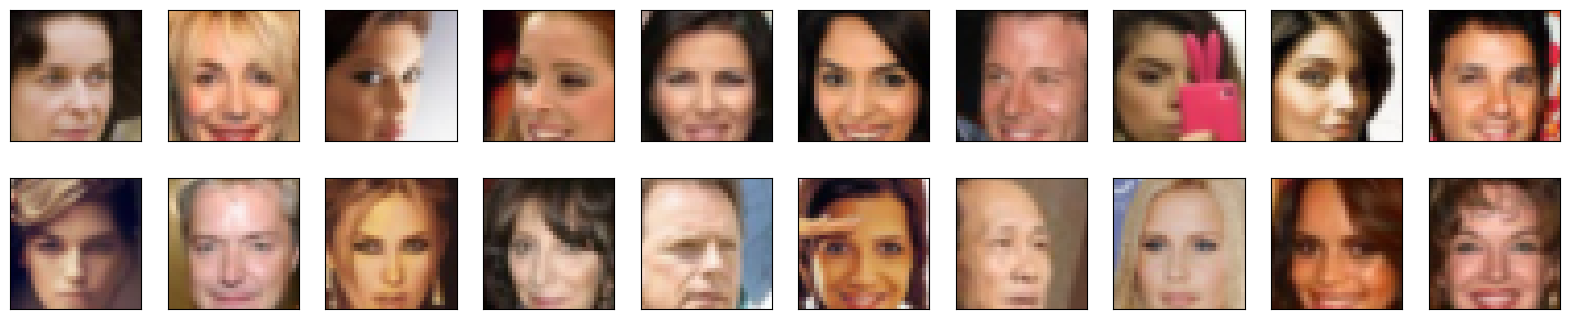

In [10]:

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(celeba_train_loader)
images, _ = next(dataiter)

# plot the images in the batch
fig = plt.figure(figsize=(20, 4))
plot_size = 20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])

In [11]:
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. '''

    max_scale = max(feature_range)
    min_scale = min(feature_range)
    
    # Scale to feature range
    x = x * (max_scale-min_scale) + min_scale
    
    return x

In [12]:
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9765)
Max:  tensor(0.8039)


In [13]:
import torch.nn as nn
import torch.nn.functional as F

In [14]:
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [15]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Discriminator
        
        """
        super(Discriminator, self).__init__()

        # define all convolutional layers
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4)
        
        # define last classification layer
        self.conv5 = conv(conv_dim*8, 1, 4, stride=1, batch_norm=False)
        
        # define activation function
        self.leakyrelu = nn.LeakyReLU()
        
        # define dropout layer
        self.dropout = nn.Dropout(0.3)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        """
        x = self.leakyrelu(self.conv1(x))
        x = self.leakyrelu(self.conv2(x))
        x = self.leakyrelu(self.conv3(x))
        x = self.dropout(x)
        x = self.leakyrelu(self.conv4(x))
        x = self.dropout(x)
        
        out = self.conv5(x).view(-1, 1)
        
        return out


In [16]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transpose convolutional layer, with optional batch normalization.
    """
    layers = []
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [17]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator
        """
        super(Generator, self).__init__()
        
        self.conv_dim = conv_dim

        ## Define input fully connected layer
        self.fcin = nn.Linear(z_size, 4*4*conv_dim*4)
        
        ## Define transpose convolutional layers
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4, batch_norm=True)
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4, batch_norm=True)
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)
        
        ## Define activation function
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        """
        ## input fully connected layer
        x = self.fcin(x)
        
        ## reshape the tensor for transpose concolutional layer
        x = x.view(-1, self.conv_dim*4, 4, 4)
        
        ## convolutional layers
        x = self.relu(self.t_conv1(x))
        x = self.relu(self.t_conv2(x))
        
        out = self.tanh(self.t_conv3(x))
        
        return out

In [18]:
from torch.nn import init

def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model  
    """
    classname = m.__class__.__name__
    
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        init.normal_(m.weight.data, 0.0, 0.02)

In [19]:
def build_network(d_conv_dim, g_conv_dim, z_size):
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    D.apply(weights_init_normal)
    G.apply(weights_init_normal)
    
    return D, G

In [20]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 64
z_size = 256

D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv5): Sequential(
    (0): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (leakyrelu): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fcin): Linear(in_features=256, out_fea

In [21]:
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


In [22]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    loss = torch.mean(D_out-1)**2
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    loss = torch.mean(D_out**2)
    return loss

In [23]:
import torch.optim as optim

lr = 0.0002
beta1 = 0.3
beta2 = 0.999

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

In [24]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling.
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)
            

            #. Train the discriminator on real and fake images
            
            d_optimizer.zero_grad()
            
            ## Compute real loss on discriminator
            
            # move real images to GPU if available
            if train_on_gpu:
                real_images = real_images.cuda()
            
            # pass real images to descriminator
            D_real = D(real_images)
            
            # compute real loss of descriminator
            d_real_loss = real_loss(D_real)
            
        
            
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
                
            # generate fake images with generator
            fake_images = G(z)
            
            # pass fake images to descriminator
            D_fake = D(fake_images)
            
            # compute fake loss of descrimintor
            d_fake_loss = fake_loss(D_fake)
            
            
            ## Compute total descriminator loss
            d_loss = d_real_loss + d_fake_loss
            
            ## Perform backprop to the descriminator
            d_loss.backward()
            d_optimizer.step()

            #Train the generator with an adversarial loss
            
            g_optimizer.zero_grad()
            
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
                
            # generate fake images
            fake_images = G(z)
            
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake)
            
            g_loss.backward()
            g_optimizer.step()

            if batch_i % print_every == 0:
                losses.append((d_loss.item(), g_loss.item()))
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses

In [25]:
# set number of epochs 
n_epochs = 20



losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   20] | d_loss: 1.2465 | g_loss: 0.4244
Epoch [    1/   20] | d_loss: 0.2312 | g_loss: 1.3970
Epoch [    1/   20] | d_loss: 0.1339 | g_loss: 0.8880
Epoch [    1/   20] | d_loss: 0.0966 | g_loss: 1.2968
Epoch [    1/   20] | d_loss: 0.2006 | g_loss: 0.7119
Epoch [    1/   20] | d_loss: 0.1044 | g_loss: 0.8881
Epoch [    1/   20] | d_loss: 0.1403 | g_loss: 1.2546
Epoch [    1/   20] | d_loss: 0.0944 | g_loss: 0.4750
Epoch [    1/   20] | d_loss: 0.1124 | g_loss: 0.7757
Epoch [    1/   20] | d_loss: 0.0752 | g_loss: 1.1378
Epoch [    1/   20] | d_loss: 0.1131 | g_loss: 0.8509
Epoch [    1/   20] | d_loss: 0.1396 | g_loss: 0.6176
Epoch [    1/   20] | d_loss: 0.1135 | g_loss: 0.5140
Epoch [    1/   20] | d_loss: 0.1323 | g_loss: 0.9155
Epoch [    1/   20] | d_loss: 0.1569 | g_loss: 0.7465
Epoch [    1/   20] | d_loss: 0.1428 | g_loss: 1.0285
Epoch [    1/   20] | d_loss: 0.2639 | g_loss: 1.2141
Epoch [    1/   20] | d_loss: 0.0543 | g_loss: 0.9763
Epoch [    1/   20] | d_loss

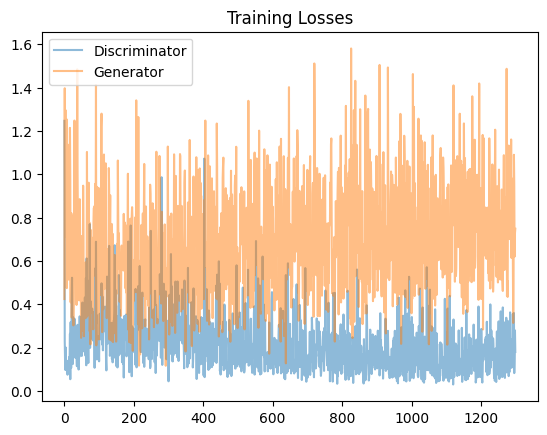

In [26]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [27]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [28]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

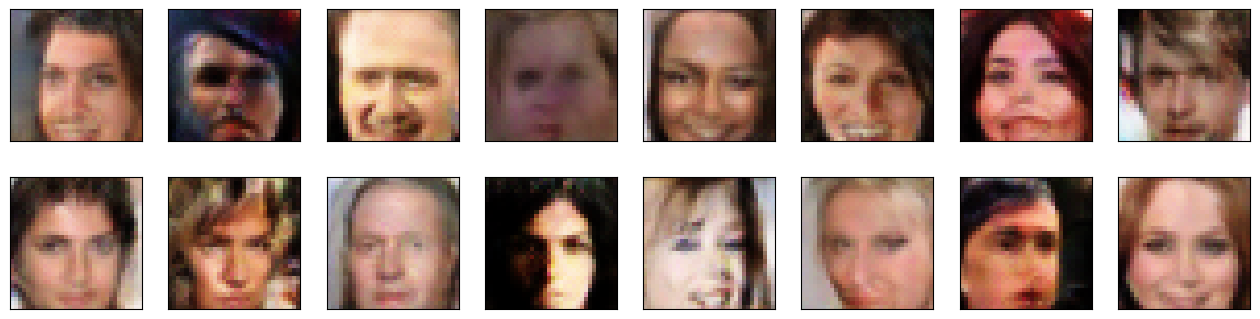

In [29]:
_ = view_samples(-1, samples)